In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from os import listdir
from os.path import isfile, join
from matplotlib.backends.backend_pdf import PdfPages
import plotly.graph_objects as go
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

In [2]:
def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, alpha=0.45, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im

In [3]:
def new_cases_per_day(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cases per day  np.array casos_por_dia
    given the days of beginning of symptoms, processes to get np.array of cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    latest update = checked the days again, it works perfectly splendid
    """
    counts = np.bincount(fecha_sintomas)
    ultima_fecha = max(fecha_sintomas)
    aux = range(ultima_fecha+1)
    casos_por_dia = np.vstack((aux,counts[aux])).T #(days since inicio_epidemia x (fecha_inicio_sintomas == days))
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.plot(casos_por_dia[:,0],casos_por_dia[:,1],'-ob',label="casos hasta dia: "+str(ultima_fecha))
        plt.style.use('ggplot')
        plt.legend()
        #plt.savefig("casos_por_dia_bariloche.pdf")
    if ret == True:
        return casos_por_dia   

In [4]:
def cumulative_cases(fecha_sintomas,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of new cases per day 
    -ret: defaults to False. if True, returns days-cumulative cases per day np array
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before
    latest update = checked the days again, it works perfectly splendid
    """
    ultima_fecha = max(fecha_sintomas)
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    casos_acumulados_por_dia = np.copy(casos_por_dia)
    casos_acumulados_por_dia[:,1] = np.cumsum(casos_por_dia[:,1]) 
    if graph == True:
        plt.xlabel("Dia")
        plt.ylabel("Casos acumulados")
        plt.axvspan(ultima_fecha-10, ultima_fecha+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(casos_acumulados_por_dia[:,0],casos_acumulados_por_dia[:,1],c='b',label="casos acumulados hasta dia: "+str(ultima_fecha))
        plt.legend()
        plt.style.use('ggplot')
        plt.savefig("casos_acumulados_bariloche.pdf")
    if ret == True:
        return casos_acumulados_por_dia   

In [5]:
def repratio_t_conv(fecha_sintomas,a,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -graph: defaults to False. if True, makes graph of rep ratio per day
    -ret: defaults to False. if True, returns reproductive ratio per day np array of (days,r_days) and
    the n_t vector which is used to calculate it, which is extension of new cases per day made as 
    necessary, by taking means and not linear regression. 
    given the days of beginning of symptoms, processes to get np.array of cumulative cases per day and days since epidemic
    can graph and return this vector with the defaults explained before for days (0,lastday+4)
    conventional version, which means no coef a,b,c,d,e. r_t valid for days >= 6. 
    latest update = checked the days again, it works perfectly splendid
    """
    casos_por_dia = new_cases_per_day(fecha_sintomas,ret=True)
    n_t = np.copy(casos_por_dia) #here we store data + proyection for days t+4 
    prox_dia = max(fecha_sintomas) + 1
    #completing the values for the rest of the values of n_t
    aux = np.zeros(2)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux[0] = prox_dia + i
        aux[1] = np.mean(n_t[prox_dia-7:,1])
        n_t  = np.vstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    #create storage and calculate values for r_t
    r_t = np.copy(n_t) #here we will store the rt
    r_t = r_t.astype(float)
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6,1] + a[1]*n_t[i-5,1] + a[2]*n_t[i-4,1] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i,1] = min(((a[3]*n_t[i-1,1] + a[4]*n_t[i,1] + a[5]*n_t[i+1,1])/(aux)),4) #the rest of the days with limit value
    if graph == True:
        plt.style.use('ggplot')
        plt.axvspan(prox_dia-10, prox_dia+3, facecolor='r', alpha=0.5,label="últimos 10 días")
        plt.scatter(r_t[6:prox_dia,0],r_t[6:prox_dia,1],c='b',label=r'$r_t$')
        plt.xlabel("Dia")
        plt.ylabel(r'$r_t$',fontsize=12)
        plt.legend()
        plt.savefig("rt_raw_casos.pdf")
    if ret == True:
        return n_t,r_t

In [6]:
def risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=False):
    """
    args: 
    -fecha_sintomas: day of beginning of symptomps for each case, can't be NaN or NaT (already processed)
    -pop: number of inhabitants of the region/population of interest
    -rep_fun: function to calculate empirical reproductive ratio. defaults tp repratio_t_conv (not optimized)
    -graph: defaults to False. if True, makes graph of risk diagram
    -ret: defaults to False. if True, returns the components of risk diagram in two np.arrays, which are
     the attack ratio (days>=20) as well as the rep ratio averaged over 7 days (days>=20). 
     latest update = checked the days again, it works perfectly splendid
    """
    #we proceed to calculate what makes a risk diagram then
    #first, we will calculate r_t average in 7 days
    prox_dia = max(fecha_sintomas) + 1
    n_t,r_t = rep_fun(fecha_sintomas,a,False,True)
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4,1])
        i = i+1
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1,1]) 
        i = i+1
    a_t = a_t * (100000/pop)
    if graph == True:
        plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5) #not at all fancy risk diagram,looks reasonable
        plt.xlabel(r'$A_{t}^{14}$')
        plt.ylabel(r'$R_{t}^{7}$')
        plt.style.use('ggplot')
        plt.title('Diagrama de riesgo Bariloche',fontsize=10)
        plt.savefig('riskdiagram_brc.pdf')
    if ret == True:
        return r_t_seven,a_t

In [7]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df1 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    df_sin_fecha = df.loc[filt_df1]
    n_size = df_sin_fecha.shape[0]
    df.loc[filt_df1,"fecha_inicio_sintomas"] = df.loc[filt_df1,"fecha_apertura"] - np.random.randint(0,9,n_size)
    filt_df2 = (df.fecha_inicio_sintomas < 0)
    df.loc[filt_df2,"fecha_inicio_sintomas"] = 0

In [21]:
def make_diagram(file):
    data = pd.read_csv("datos_12en20/"+file,sep=",",quotechar='"',
                       parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) #data loading
    df = pd.DataFrame(data) #converting to dataframe for use
    filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
    inicio_epidemia = min(df.loc[filt_df1,"fecha_inicio_sintomas"]) #first symptoms of a person registered
    ultima_actualizacion_sintomas = max(df.loc[filt_df1,"fecha_inicio_sintomas"]) #last day symptoms of a person registered
    ultima_actualizacion_apertura = max(df["fecha_apertura"])
    df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
    df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
    df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
    df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
    change_dates(df) #replaces non existing fecha_inicio_sintomas acc to new criteria
    fecha_sintomas = df.fecha_inicio_sintomas.to_numpy() #numpy array of fecha_inicio_sintomas
    fecha_apertura = df.fecha_apertura.to_numpy() #numpy array of fecha_apertura
    fecha_sintomas = fecha_sintomas.astype(int)
    pop = 163743
    a = np.zeros(6) + 1
    p_seven,a_14_days = risk_diagram(fecha_sintomas,pop,a,rep_fun=repratio_t_conv,graph=False,ret=True)
    fig1, ax1 = plt.subplots()
    ax1.plot(a_14_days, p_seven, 'ko--', fillstyle='none', linewidth=0.5)
    lim = ax1.get_xlim()
    x = np.ones(int(lim[1]))
    ax1.plot(x, 'k-', fillstyle='none', linewidth=0.5)
    ax1.set_ylim(0, 4)
    ax1.set_xlim(0, max(a_14_days+2))
    ax1.set_ylabel(r'$R_{t}^{7}$',fontsize=14)
    ax1.set_xlabel(r'$A_{t}^{14}$',fontsize=14)
    ax1.annotate(inicio_epidemia.date(),
                xy=(a_14_days[0], p_seven[0]), xycoords='data',
                xytext=(len(x) - abs(len(x) / 1.13), 0.5), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3", linewidth=0.8,color='black'),color='black',fontsize=12
                )
    ax1.annotate(ultima_actualizacion_apertura.date(),
                xy=(a_14_days[len(a_14_days) - 1], p_seven[len(p_seven) - 1]), xycoords='data',
                xytext=(len(x) - abs(len(x) /4), 2.0), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                connectionstyle="arc3", linewidth=0.8,color='black'),color='black',fontsize=12
                )
    color_map = plt.cm.hsv
    cmap = color_map.reversed()
    for i in a_14_days:
        if i < 30:
            c_min = 0.6
            c_max = 0.89
        elif 30 > i < 100:
            c_min = 0.65
            c_max = 0.95
        elif 100 > i < 200:
            c_min = 0.65
            c_max = 1.1
        else:
            c_min = 0.65
            c_max = 1.3
    gi = gradient_image(ax1, direction=0.6, extent=(0, 1, 0, 1), transform=ax1.transAxes,
                    cmap=cmap, cmap_range=(c_min, c_max))
    #fig1.colorbar(gi, ax=ax1)
    ax1.set_aspect('auto')
    fig1.tight_layout()
    plt.title('Diagrama de Riesgo - '+file[6:-4],fontsize=14)
    plt.show()

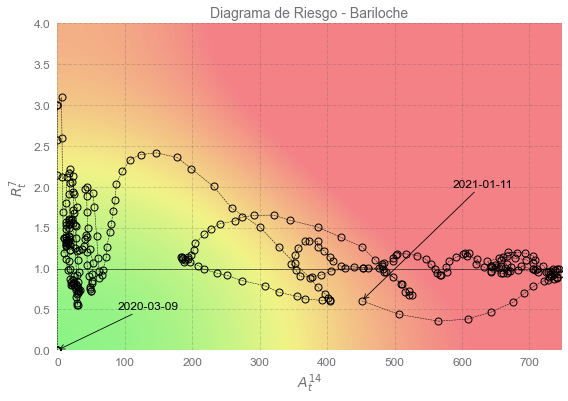

In [22]:
file = "casos_Bariloche.txt"
make_diagram(file)